# GLORYs Bias Corrections

I don't want to deal with creating and saving date keys just to do the bais corrections in R again. We can skip that organizational hurdle by keeping things in python.

This notebook will handle the following things:

 * Load data from our suite of CMIP models, matching historical periods to projections
 * Regrid the CMIP6 data to a common resolution
 * Build climatologies for each for a reference period which we can match with GLORYS
 * Determine seasonal biases (deltas) between CMIP models and the GLORYs climatology
 * Use monthly/seasonal deltas to bias-correct CMIP model monthly/seasonal anomalies



In [1]:
import glob             # for file listing
import xarray as xr     # for netcdfs
import numpy as np      # array tools
import fcts             # local functions
import xmip             # common preprocessing for cmip6 data
import xesmf as xe      # irregular grid support and interpolation methods
import dask
from matplotlib import pyplot as plt
import os
import cftime
import pandas as pd

# Function to help handle irregular grids
from xmip.preprocessing import replace_x_y_nominal_lat_lon

# Selecting datasets to plot from dictionaries
from itertools import islice


### Modify xmip preprocessing

Our downloading/extracting of surface/bottom layers interferes with the expected structure of some datasets and some metadata. This impacts our ability to use `xmip.preprocessing.combined_preprocessing()` in its original form. I've modified it below so that it still runs:

In [2]:
# XMIP preprocessing function
# from xmip.preprocessing import combined_preprocessing


# Is it the stupid metadata? - yes, alter that step out
# https://github.com/jbusecke/xMIP/blob/108266e72d01c173e15cdf4ca00612a0d4f0a8ca/xmip/preprocessing.py#L18
def combined_preprocessing(ds):

    # variables to drop
    _drop_coords = ["bnds", "vertex"]

    # fix naming
    ds = xmip.preprocessing.rename_cmip6(ds)
    # promote empty dims to actual coordinates
    ds = xmip.preprocessing.promote_empty_dims(ds)
    # demote coordinates from data_variables
    ds = xmip.preprocessing.correct_coordinates(ds)
    # broadcast lon/lat
    ds = xmip.preprocessing.broadcast_lonlat(ds)
    # shift all lons to consistent 0-360
    ds = xmip.preprocessing.correct_lon(ds)
    # fix the units
    ds = xmip.preprocessing.correct_units(ds)
    # rename the `bounds` according to their style (bound or vertex)
    ds = xmip.preprocessing.parse_lon_lat_bounds(ds)
    # sort verticies in a consistent manner
    ds = xmip.preprocessing.sort_vertex_order(ds)
    # convert vertex into bounds and vice versa, so both are available
    ds = xmip.preprocessing.maybe_convert_bounds_to_vertex(ds)
    ds = xmip.preprocessing.maybe_convert_vertex_to_bounds(ds)
    #ds = fix_metadata(ds)
    ds = ds.drop_vars(_drop_coords, errors="ignore")
    return ds


In [3]:

def standardize_calendar(ds, target_calendar):
    
    # Check if the time index is cftime-based
    time_values = ds['time'].values
    
    if isinstance(time_values[0], cftime.datetime):
        
        # Extract the current calendar
        current_calendar = time_values[0].calendar
        
        # If its not target, change it
        if current_calendar != target_calendar:
            
            # Generate a new time index in the target calendar
            new_time = xr.cftime_range(
                start    = time_values[0],
                periods  = len(time_values),
                freq     = "ME",  # Adjust frequency as needed
                calendar = target_calendar)
            
            # Reindex the dataset
            ds = ds.copy()  # Avoid in-place modifications
            ds = ds.assign_coords(time = new_time)
    
    # If its
    elif isinstance(time_values[0], np.datetime64):
        
        # If time is Gregorian, convert it to the target cftime calendar
        new_time = xr.cftime_range(
            start   = str(time_values[0]).replace(":00:00.000000000", ""),
            periods = len(time_values),
            freq    = "ME",
            calendar = target_calendar)
        ds = ds.copy()
        ds = ds.assign_coords(time = new_time)
    return ds

# Pick CMIP Scenario & Variable to Process

The code chunks below will be set up to process one variable at a time. We have four variable options stored: surf_temp, bot_temp, surf_sal, bot_sal. 

In [4]:
# User info for paths to data and for exporting:
UsrName          = 'adamkemberling'
Group            = 'RES_Data'

# Scenario Details
Experiment       = 'ssp585'
Folder           = 'CMIP6/'
ExperimentFolder = 'CMIP6/SSP5_85/'

# # Set up paths - if fcts works
# CMIPpath = fcts.shared_path(user_name = UsrName, group = Group, folder = Folder)
#ExperimentPath = fcts.shared_path(user_name = UsrName, group = Group, folder = ExperimentFolder)

# Or manually set paths to resources
CMIPpath       = f"/Users/{UsrName}/Library/CloudStorage/Box-Box/RES_Data/{Folder}"
ExperimentPath = f"/Users/{UsrName}/Library/CloudStorage/Box-Box/RES_Data/{ExperimentFolder}"
HistoricalPath = f"/Users/{UsrName}/Library/CloudStorage/Box-Box/RES_Data/{Folder}Historical/"
glorys_path    = f"/Users/{UsrName}/Library/CloudStorage/Box-Box/RES_Data/GLORYs/NW_Atl_MonthlyTemps/"

## Set the Variables to Process

 * Pick the variable, also sets the save names
 * Set the climatology period

In [5]:
# Variable Pick - matches glorys data
# var_choice = "surf_temp" # Works
var_choice = "bot_temp"    # Damn, maybe its a depth thing?
# var_choice = "surf_sal"
# var_choice = "bot_sal"

# Variable options, these are the variable names in the datasets cmip datasets
var_options = {
    "surf_sal"  : "so",
    "bot_sal"   : "so",
    "surf_temp" : "tos",
    "bot_temp"  : "thetao"}

# select the relevant one
cmip_var = var_options[var_choice]
#var_folder = var_folder_key[var_choice]

# Set min/max years for climatology
clim_min = 1993
clim_max = 2023

## List Paths to Historical and Scenario Projection Datasets

These were each downloaded with one variable to limit the filesizes. Historical files are stored+organized together in their own directory. Their filenames contain information on the variables they hold, CMIP6 experiment info, as well as the institution that produced the model. For more details on the naming look here [in this document](https://docs.google.com/document/d/1h0r8RZr_f3-8egBMMh7aqLwy3snpD6_MrDz1q8n5XUk/edit?tab=t.0)

In [6]:
# Paths to Historical datasets that were regridded with cdo tools
hist_ds = glob.glob(f'{HistoricalPath}RawTmpFiles/{cmip_var}*_historical*')

# Paths to scenario datasets that were regridded with cdo tools
scenario_ds = glob.glob(f'{ExperimentPath}RawTmpFiles/{cmip_var}*_{Experiment}*')
scenario_ds[0]

'/Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/SSP5_85/RawTmpFiles/thetao_FIO-ESM-2-0_r1i1p1f1_ssp585.nc'

## Matching+Concatenating Historic and Projection Periods

Historical periods and SSP scenario projections were downloaded separately and are stored independently. 

There are instances where they are available for one period and not the other. The nexxt section matches the two periods based on the institution and the experiment IDs to create one continuous matching record.

In [7]:
# Put them each in dictionaries by their experiment info

# Function to extract the common part of the filename
def get_common_part(filename, suffix):
    base_name = os.path.basename(filename)  # Get the base name
    base_name = base_name.replace(suffix, "")  # Remove the suffix
    base_name = base_name.replace("GlorysGrid_", "")  # Remove the prefix if we have it
    base_name = base_name.replace("StGrid_", "")  # Remove the prefix if we have it
    return base_name 

In [8]:
# Get experiment info from each list
common_parts_1 = {get_common_part(file, "_historical.nc"): file for file in hist_ds}
common_parts_2 = {get_common_part(file, f"_{Experiment}.nc"): file for file in scenario_ds}

# Build a dictionary to store matches
matched_files = {}

# Keep only matches that exist in both lists
for common_part in common_parts_1.keys() & common_parts_2.keys():
    matched_files[common_part] = [common_parts_1[common_part], common_parts_2[common_part]]

# Append Historical & Projection Periods

At this point we can attach the historical periods to scenario projections produced by the same institution and under the same experimental conditions.

#### Additional Pre-processing via `xmip`

Matched datasets are formatted at this step using `xmip`'s preprocessing functions. These functions help eliminate inconsistencies in coordinate/variable/dimension names and units, and make it easier to work with them in the same pipeline.

For more details and tutorials see [xmip tutorials here](https://github.com/jbusecke/xMIP/blob/main/docs/tutorial.ipynb).

#### Date Formatting

This is also be a good place to make sure the datetimes are the same type and span the correct periods. There are two main datetime classes present: `datetime64` and `DatetimeProlepticGregorian` from `cftime` which are times which follow [CF metadata conventions](http://cfconventions.org) which were designed to standardize formatting for climate forecasting datasets.


In [9]:
# What even are the calendars:

# numpy.datetime64
# cftime._cftime.DatetimeNoLeap
# cftime._cftime.Datetime360Day
# cftime._cftime.DatetimeProlepticGregorian
# Then if decode_times = False: numpy.int64

# # Standardize all datasets in the dictionary
# for key, ds in matched_files.items():

#     # Open both files as datasets
#     d1 = xr.open_dataset(ds[0]) 
#     d1_calendar = type(d1['time'].values[0])
#     d2 = xr.open_dataset(ds[1])
#     d2_calendar = type(d2['time'].values[0])
#     print(f"Date formats: {d1_calendar} & {d2_calendar}")

In [10]:
# Match up the projections to the historical periods

# Function to append NetCDF files along the time dimension
def append_netcdf_files(file_pair):
    
    # Open both files as datasets
    # datasets = [xr.open_dataset(file, chunks = {"time": 100}) for file in file_pair]
    datasets = [xr.open_dataset(file) for file in file_pair]

    # Apply xmip preprocessing
    datasets = [combined_preprocessing(ds) for ds in datasets]

    # # Standardize the calendars
    datasets = [standardize_calendar(ds, TARGET_CALENDAR) for ds in datasets]
    
    # Concatenate along the time dimension
    concatenated = xr.concat(datasets, dim = "time")

    # Subset anything that extends past 2100, doesn't work on all
    concatenated = concatenated.sel(time = concatenated.time.dt.year <= 2100)

    # Close the datasets
    for ds in datasets:
        ds.close()
    return concatenated



In [11]:
# Define the target calendar type
TARGET_CALENDAR = "noleap"
# TARGET_CALENDAR = "360_day"

# Process all matched files
concatenated_datasets = {}
failed_concats = []
for key, file_pair in matched_files.items():
    
    try:
        print(f"Concatenating: {key}")
        concatenated_datasets[key] = append_netcdf_files(file_pair)
    
    except:
        print(f"Problem Appending Historic to Projection Periods for {key}")
        concatenated_datasets[key] = None
        failed_concats.append(key)

# Remove None values
concatenated_datasets = {k: v for k, v in concatenated_datasets.items() if v is not None}

Concatenating: thetao_EC-Earth3-Veg-LR_r1i1p1f1
Concatenating: thetao_MIROC6_r1i1p1f1
Concatenating: thetao_INM-CM5-0_r1i1p1f1
Concatenating: thetao_FGOALS-f3-L_r1i1p1f1
Concatenating: thetao_CMCC-CM2-SR5_r1i1p1f1
Concatenating: thetao_CESM2_r4i1p1f1
Concatenating: thetao_NorESM2-MM_r1i1p1f1
Concatenating: thetao_GISS-E2-1-G_r1i1p3f1
Concatenating: thetao_IPSL-CM6A-LR_r1i1p1f1
Concatenating: thetao_NorESM2-LM_r1i1p1f1
Concatenating: thetao_FGOALS-g3_r1i1p1f1
Concatenating: thetao_FIO-ESM-2-0_r1i1p1f1
Concatenating: thetao_CESM2-WACCM_r1i1p1f1
Concatenating: thetao_NESM3_r1i1p1f1
Concatenating: thetao_EC-Earth3-Veg_r1i1p1f1
Concatenating: thetao_EC-Earth3_r1i1p1f1
Concatenating: thetao_MRI-ESM2-0_r1i1p1f1
Problem Appending Historic to Projection Periods for thetao_MRI-ESM2-0_r1i1p1f1
Concatenating: thetao_INM-CM4-8_r1i1p1f1


/Users/adamkemberling/Documents/Repositories/lobSDM/.pixi/envs/default/lib/python3.10/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamkemberling/Documents/Repositories/lobSDM/.pixi/envs/default/lib/python3.10/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


Concatenating: thetao_CIESM_r1i1p1f1
Concatenating: thetao_CNRM-ESM2-1_r4i1p1f2
Concatenating: thetao_UKESM1-0-LL_r1i1p1f2
Concatenating: thetao_CanESM5_r1i1p2f1
Concatenating: thetao_CNRM-CM6-1_r1i1p1f2
Concatenating: thetao_GFDL-CM4_r1i1p1f1
Concatenating: thetao_MIROC-ES2L_r1i1p1f2
Concatenating: thetao_CanESM5-CanOE_r1i1p2f1


In [13]:
# # Debug failures - woohoo!
print(f"{len(failed_concats)} failed pairs")
matched_files[failed_concats[0]]

1 failed pairs


['/Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/Historical/RawTmpFiles/thetao_MRI-ESM2-0_r1i1p1f1_historical.nc',
 '/Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/SSP5_85/RawTmpFiles/thetao_MRI-ESM2-0_r1i1p1f1_ssp585.nc']

### Double Check Extents?

I see for `thetao_CESM2_r4i1p1f1` that there is both some striping going on and a weird slice of the lat/lon extent is extending outside of our target area. Would be good to slice it, but I don't want to introduce more work

In [14]:
# This one is a known issue, and I think it was originally just subset/cropped improperly
if var_choice == "bot_temp":
    del concatenated_datasets["thetao_CESM2_r4i1p1f1"]

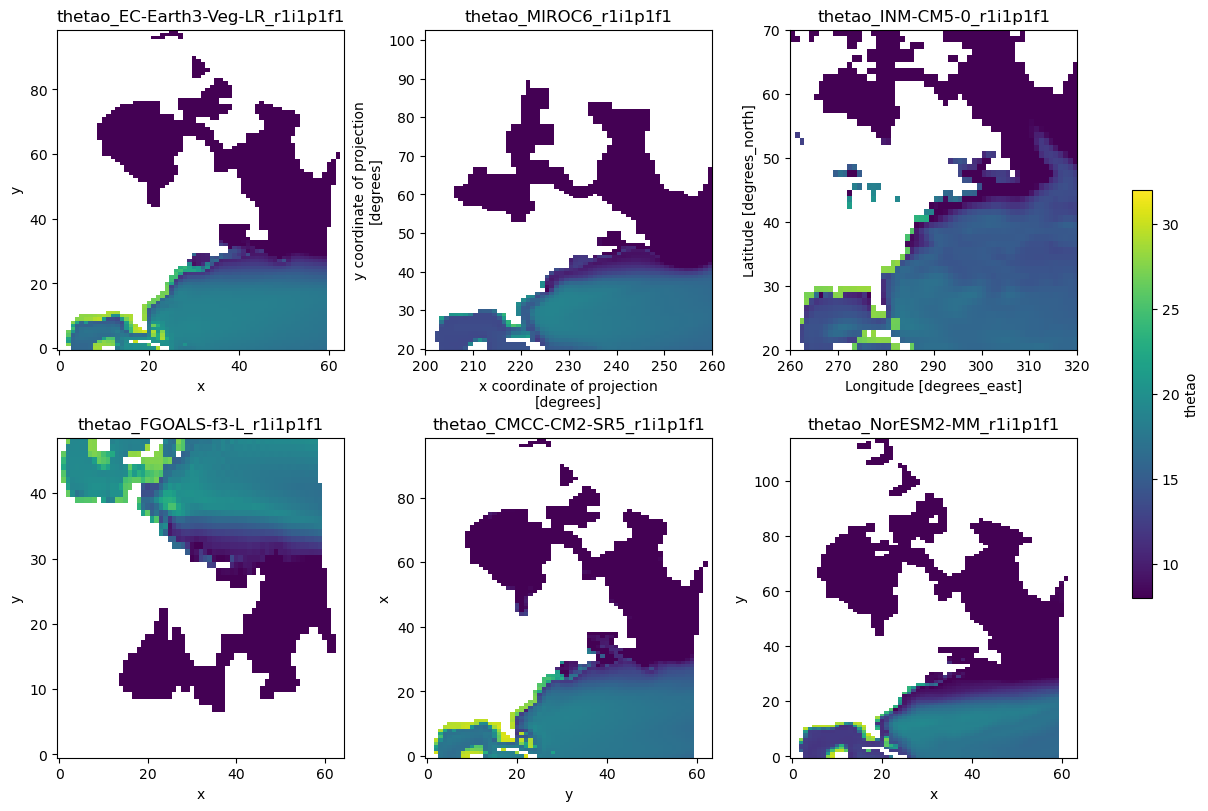

In [15]:
# First six keys and datasets
keys_to_plot = list(islice(concatenated_datasets.keys(), 6))
datasets_to_plot = [concatenated_datasets[key] for key in keys_to_plot]

# Create a 3x2 grid for plotting
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its corresponding subplot
for i, (data, ax) in enumerate(zip(datasets_to_plot, axes)):
    
    # Assuming time indexing, you might need to select a specific time index here:
    data = data.isel(time = 20)
    
    im = data[cmip_var].plot(ax=ax, vmin = 8, vmax = 32, add_colorbar=False)
    ax.set_title(f"{keys_to_plot[i]}")  # Add title for clarity

# Add a single shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label(cmip_var)

# Hide any unused axes if datasets < grid size
for ax in axes[len(datasets_to_plot):]:
    ax.axis("off")

# Show the plot
plt.show()

 ## Load + Interpolate to the GLORYS Resolution

 We're using GLORYs as the observational data for bias correction. This was downloaded from mercator-ocean using their python api. This was then processed into monthly averages for the climate reference period.
 
 I tested interpolating using the cdo tools code that we had against interpolating using xarray in this notebook and with the settings/methods we were using for both the xarray method seemed more fluid, and did not have a bubbling effect like what could be seen with the cdo tools datasets.

 The next chunk will interpolate each of the concatenated datasets into consistent datasets spanning the lead-in and projection periods.

In [16]:
# Load the reference grid we want to regrid to
glorys_grid = f"{glorys_path}TempSalClimatology1993to2023.nc" # Has salinity and temperature
#glorys_grid = f"{glorys_path}Climatology1993to2023.nc" # No salinity

glorys_clim = xr.open_dataset(glorys_grid)
#glorys_clim.isel(month = 0).surf_temp.plot()

## Perform Regridding

I'm running into issues with things not regridding properly for irregular grids, and using xmip preprocessing does resolves some but not all of these issues. 

Here are some notes on how to maybe improve this process in the future from [this ebook](https://earth-env-data-science.github.io/lectures/models/regridding.html)

Ultimately which method you use will depend on the particular use case. Before regridding, carefully inspect your datasets and think of what you want to achieve:

Are both datasets of a similar resolution and relatively smooth? Then using linear interpolation should be acceptable and is by far the easiest way to compare the datasets.

Is the goal of the comparison to evaluate differences on larger scales than the grid scale? Then create a coarser grid and interpolate conservatively to gain a larger scale perspective without getting distracted by smaller scale features.

In [17]:
# Interpolation using xesmf
# Check if its a multiIndex / irregular grid situation
regrid_ds = {}
failed_regrids = []
for id, dataset in concatenated_datasets.items():
    print(f"Regridding: {id}")
    
    try: 
        # Make the regridder
        #Since this is not global we don't need to pass periodic
        regridder = xe.Regridder(dataset, glorys_clim, 'bilinear', periodic = False) 

        # Put it into the dict
        regrid_ds[id] =  regridder(dataset)
        
    except:
        print(f"Failed Regridding for: {id}, removed")
        regrid_ds[id] = None
        failed_regrids.append(key)
    
# Remove None values
regrid_ds = {k: v for k, v in regrid_ds.items() if v is not None}
    

Regridding: thetao_EC-Earth3-Veg-LR_r1i1p1f1
Regridding: thetao_MIROC6_r1i1p1f1
Regridding: thetao_INM-CM5-0_r1i1p1f1


/Users/adamkemberling/Documents/Repositories/lobSDM/.pixi/envs/default/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Regridding: thetao_FGOALS-f3-L_r1i1p1f1
Regridding: thetao_CMCC-CM2-SR5_r1i1p1f1
Regridding: thetao_NorESM2-MM_r1i1p1f1
Regridding: thetao_GISS-E2-1-G_r1i1p3f1
Failed Regridding for: thetao_GISS-E2-1-G_r1i1p3f1, removed
Regridding: thetao_IPSL-CM6A-LR_r1i1p1f1
Regridding: thetao_NorESM2-LM_r1i1p1f1
Regridding: thetao_FGOALS-g3_r1i1p1f1
Regridding: thetao_FIO-ESM-2-0_r1i1p1f1
Failed Regridding for: thetao_FIO-ESM-2-0_r1i1p1f1, removed
Regridding: thetao_CESM2-WACCM_r1i1p1f1
Regridding: thetao_NESM3_r1i1p1f1
Regridding: thetao_EC-Earth3-Veg_r1i1p1f1
Regridding: thetao_EC-Earth3_r1i1p1f1
Regridding: thetao_INM-CM4-8_r1i1p1f1


/Users/adamkemberling/Documents/Repositories/lobSDM/.pixi/envs/default/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Regridding: thetao_CIESM_r1i1p1f1
Regridding: thetao_CNRM-ESM2-1_r4i1p1f2
Regridding: thetao_UKESM1-0-LL_r1i1p1f2
Regridding: thetao_CanESM5_r1i1p2f1
Regridding: thetao_CNRM-CM6-1_r1i1p1f2
Regridding: thetao_GFDL-CM4_r1i1p1f1
Regridding: thetao_MIROC-ES2L_r1i1p1f2
Regridding: thetao_CanESM5-CanOE_r1i1p2f1


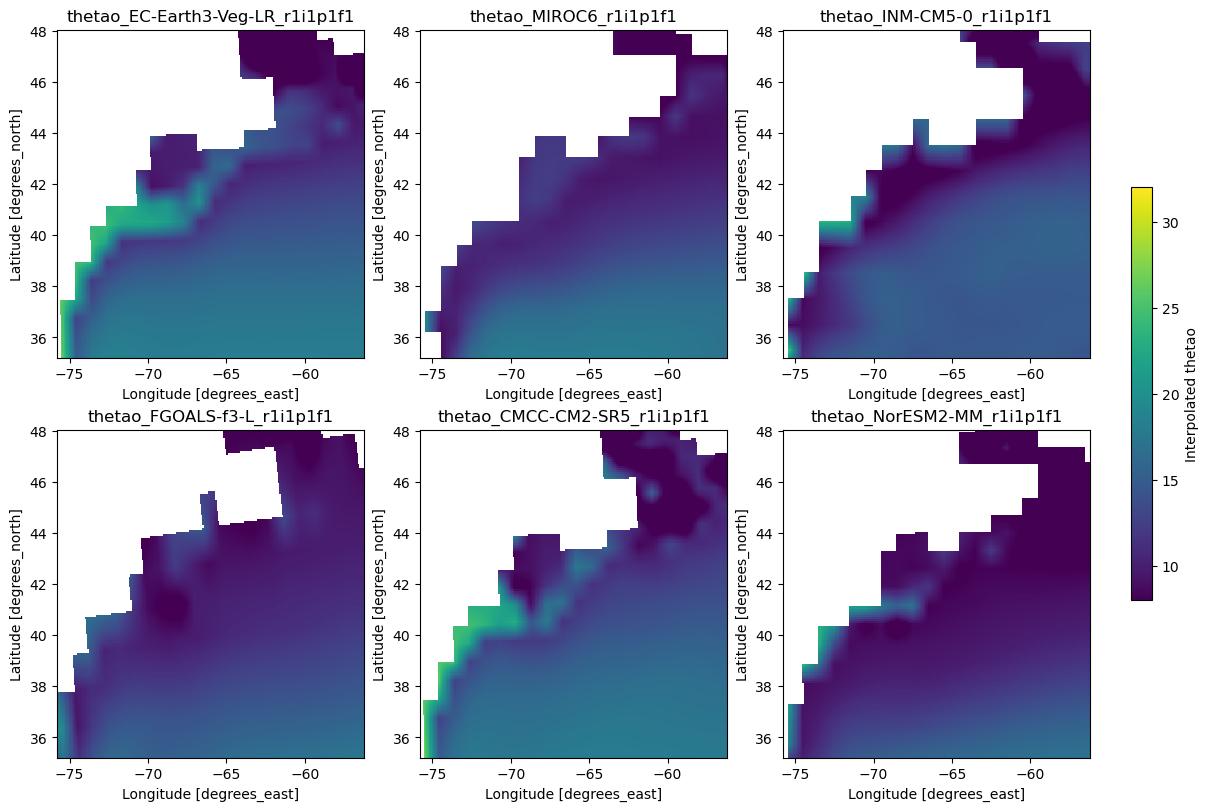

In [18]:
# Select datasets to plot
keys_to_plot = list(islice(regrid_ds.keys(), 6))
datasets_to_plot = [regrid_ds[key] for key in keys_to_plot]

# Create a 3x2 grid for plotting
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its corresponding subplot
for i, (data, ax) in enumerate(zip(datasets_to_plot, axes)):
    
    # Assuming time indexing, you might need to select a specific time index here:
    data = data.isel(time = 20)
    
    im = data[cmip_var].plot(ax=ax, vmin = 8, vmax = 32, add_colorbar=False)
    ax.set_title(f"{keys_to_plot[i]}")  # Add title for clarity

# Add a single shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label(f"Interpolated {cmip_var}")

# Hide any unused axes if datasets < grid size
for ax in axes[len(datasets_to_plot):]:
    ax.axis("off")

# Show the plot
plt.show()

# Process Climatologies for Each Using Shared Reference Period

Each pair (historic + projection) will get its own monthly climatology. 

This is used to compare against the observation dataset (GLORYs) to determine biases.

The climatological reference period for both the CMIP experiment and the glorys climatology should match.

In [19]:
# Build historical climatologies
monthly_clims = {}
failed_clims = []
for key, concat_ds in regrid_ds.items():
    
    try:
        # Slice to climatology period
        #clim_ds = concat_ds.sel(time = slice(f"{clim_min}-01-01", f"{clim_max}-12-30")) # can't use if the
        clim_ds = concat_ds.sel(time = (concat_ds.time.dt.year >= clim_min) & (concat_ds.time.dt.year <= clim_max))
        clim_ds = clim_ds.groupby("time.month").mean(dim = "time")
        
        # Get monthly means
        print(f"Processing Climatology for: {key}")
        monthly_clims[key] = clim_ds
    
    except:
        print(f"Failed for: {key}")
        monthly_clims[id] = None
        failed_clims.append(key)
    
# Remove None values, record failures
monthly_clims = {k: v for k, v in monthly_clims.items() if v is not None}

Processing Climatology for: thetao_EC-Earth3-Veg-LR_r1i1p1f1
Processing Climatology for: thetao_MIROC6_r1i1p1f1
Processing Climatology for: thetao_INM-CM5-0_r1i1p1f1
Processing Climatology for: thetao_FGOALS-f3-L_r1i1p1f1
Processing Climatology for: thetao_CMCC-CM2-SR5_r1i1p1f1
Processing Climatology for: thetao_NorESM2-MM_r1i1p1f1
Processing Climatology for: thetao_IPSL-CM6A-LR_r1i1p1f1
Processing Climatology for: thetao_NorESM2-LM_r1i1p1f1
Processing Climatology for: thetao_FGOALS-g3_r1i1p1f1
Processing Climatology for: thetao_CESM2-WACCM_r1i1p1f1
Processing Climatology for: thetao_NESM3_r1i1p1f1
Processing Climatology for: thetao_EC-Earth3-Veg_r1i1p1f1
Processing Climatology for: thetao_EC-Earth3_r1i1p1f1
Processing Climatology for: thetao_INM-CM4-8_r1i1p1f1
Processing Climatology for: thetao_CIESM_r1i1p1f1
Processing Climatology for: thetao_CNRM-ESM2-1_r4i1p1f2
Processing Climatology for: thetao_UKESM1-0-LL_r1i1p1f2
Processing Climatology for: thetao_CanESM5_r1i1p2f1
Processing Cli

# Get Monthly Biases


In [20]:
# Build Monthly Climatological Biases
monthly_biases = {}
failed_bias = []
for key, clim_ds in monthly_clims.items():
    
    try:
        # Match the months, get the difference
        bias_ds = clim_ds[cmip_var] - glorys_clim.rename({var_choice : cmip_var})[cmip_var]
        bias_ds = bias_ds.to_dataset(name = cmip_var)
        # 
        print(f"Processing Monthly Biases for: {key}")
        monthly_biases[key] = bias_ds
    except:
        print(f"Failed Biases for: {key}")
        monthly_biases[id] = None
        failed_bias.append(key)
    
# Remove None values for failures
monthly_biases = {k: v for k, v in monthly_biases.items() if v is not None}

Processing Monthly Biases for: thetao_EC-Earth3-Veg-LR_r1i1p1f1
Processing Monthly Biases for: thetao_MIROC6_r1i1p1f1
Processing Monthly Biases for: thetao_INM-CM5-0_r1i1p1f1
Processing Monthly Biases for: thetao_FGOALS-f3-L_r1i1p1f1
Processing Monthly Biases for: thetao_CMCC-CM2-SR5_r1i1p1f1
Processing Monthly Biases for: thetao_NorESM2-MM_r1i1p1f1
Processing Monthly Biases for: thetao_IPSL-CM6A-LR_r1i1p1f1
Processing Monthly Biases for: thetao_NorESM2-LM_r1i1p1f1
Processing Monthly Biases for: thetao_FGOALS-g3_r1i1p1f1
Processing Monthly Biases for: thetao_CESM2-WACCM_r1i1p1f1
Processing Monthly Biases for: thetao_NESM3_r1i1p1f1
Processing Monthly Biases for: thetao_EC-Earth3-Veg_r1i1p1f1
Processing Monthly Biases for: thetao_EC-Earth3_r1i1p1f1
Processing Monthly Biases for: thetao_INM-CM4-8_r1i1p1f1
Processing Monthly Biases for: thetao_CIESM_r1i1p1f1
Processing Monthly Biases for: thetao_CNRM-ESM2-1_r4i1p1f2
Processing Monthly Biases for: thetao_UKESM1-0-LL_r1i1p1f2
Processing Mont

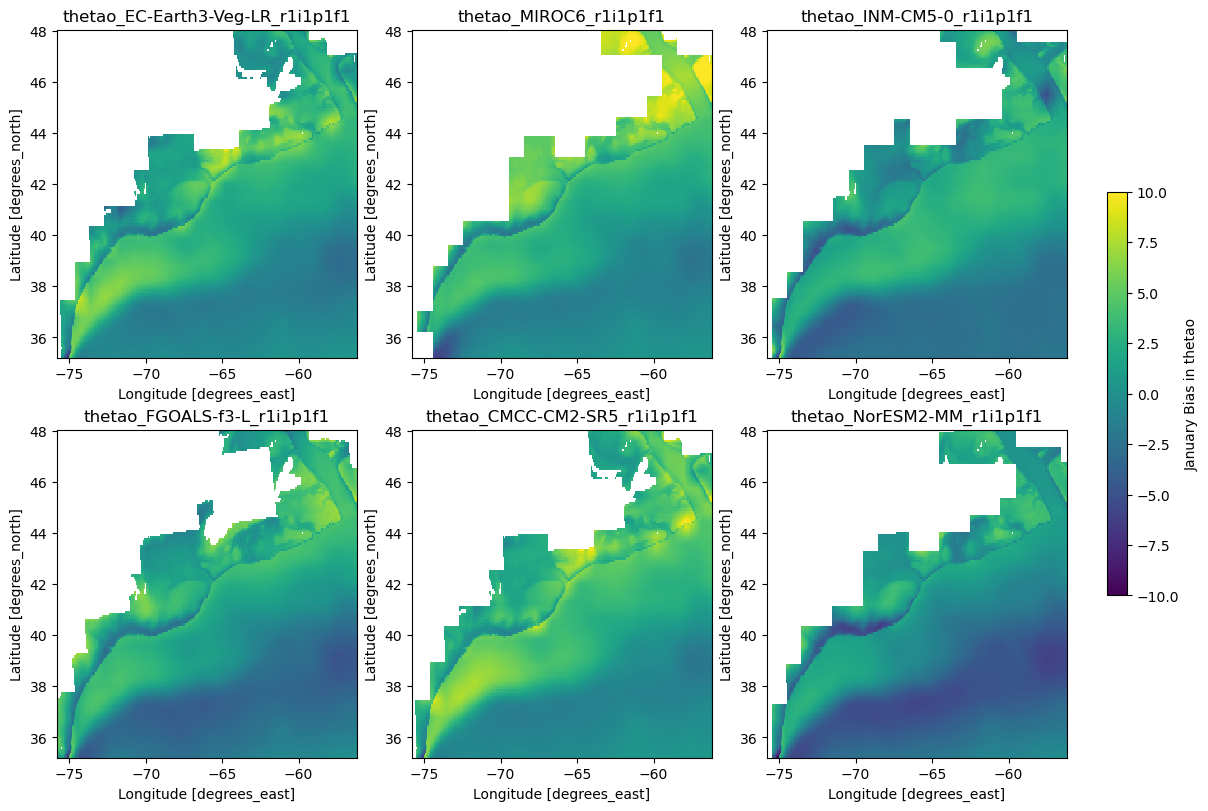

In [21]:

# Select datasets to plot
keys_to_plot = list(islice(monthly_biases.keys(), 6))
datasets_to_plot = [monthly_biases[key] for key in keys_to_plot]

# Create a 3x2 grid for plotting
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its corresponding subplot
for i, (data, ax) in enumerate(zip(datasets_to_plot, axes)):
    
    # Assuming time indexing, you might need to select a specific time index here:
    data = data.isel(month = 0)
    
    im = data[cmip_var].plot(ax=ax, vmin = -10, vmax = 10, add_colorbar=False)
    ax.set_title(f"{keys_to_plot[i]}")  # Add title for clarity

# Add a single shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label(f"January Bias in {cmip_var}")

# Hide any unused axes if datasets < grid size
for ax in axes[len(datasets_to_plot):]:
    ax.axis("off")

# Show the plot
plt.show()

# Bias Correct Monthly Scenario Data

We can rejoin the bases, or match them as we go, but these biases are now ready to be used for bias correcting each of the datasets. 

In [22]:
# Remove Biases
corrected_ds = {}
failed_debias = []
for key, concat_ds in regrid_ds.items():

    try:
        # Get the right biases using the key
        print(f"Adjusting Biases for: {key}")
        ds1 = concat_ds
        ds2 = monthly_biases[key]

        # # Group the dataset by month
        # monthly_ds = concat_ds.groupby("time.month")

        # Step 1: Extract month from ds1
        ds1["month"] = ds1["time"].dt.month

        # Step 2: Align ds1 with ds2 by broadcasting
        aligned_ds2 = ds2.sel(month = ds1["month"])

        # Step 3: Perform the subtraction to correct bias
        result = ds1[cmip_var] - aligned_ds2[cmip_var]

        # Final result as a new dataset
        #result_ds = xr.Dataset({"difference": ("time", result)}, coords={"time": ds1["time"]})
        corrected_ds[key] = result.to_dataset(name = f"bias_corrected_{cmip_var}")

    except: 
        print(f"Failed bias removal for: {key}")
        corrected_ds[id] = None
        failed_debias.append(key)
    
# Remove None values for failures
corrected_ds = {k: v for k, v in corrected_ds.items() if v is not None}

Adjusting Biases for: thetao_EC-Earth3-Veg-LR_r1i1p1f1
Adjusting Biases for: thetao_MIROC6_r1i1p1f1
Adjusting Biases for: thetao_INM-CM5-0_r1i1p1f1
Adjusting Biases for: thetao_FGOALS-f3-L_r1i1p1f1
Adjusting Biases for: thetao_CMCC-CM2-SR5_r1i1p1f1
Adjusting Biases for: thetao_NorESM2-MM_r1i1p1f1
Adjusting Biases for: thetao_IPSL-CM6A-LR_r1i1p1f1
Adjusting Biases for: thetao_NorESM2-LM_r1i1p1f1
Adjusting Biases for: thetao_FGOALS-g3_r1i1p1f1
Adjusting Biases for: thetao_CESM2-WACCM_r1i1p1f1
Adjusting Biases for: thetao_NESM3_r1i1p1f1
Adjusting Biases for: thetao_EC-Earth3-Veg_r1i1p1f1
Adjusting Biases for: thetao_EC-Earth3_r1i1p1f1
Adjusting Biases for: thetao_INM-CM4-8_r1i1p1f1
Adjusting Biases for: thetao_CIESM_r1i1p1f1
Adjusting Biases for: thetao_CNRM-ESM2-1_r4i1p1f2
Adjusting Biases for: thetao_UKESM1-0-LL_r1i1p1f2
Adjusting Biases for: thetao_CanESM5_r1i1p2f1
Adjusting Biases for: thetao_CNRM-CM6-1_r1i1p1f2
Adjusting Biases for: thetao_GFDL-CM4_r1i1p1f1
Adjusting Biases for: thet

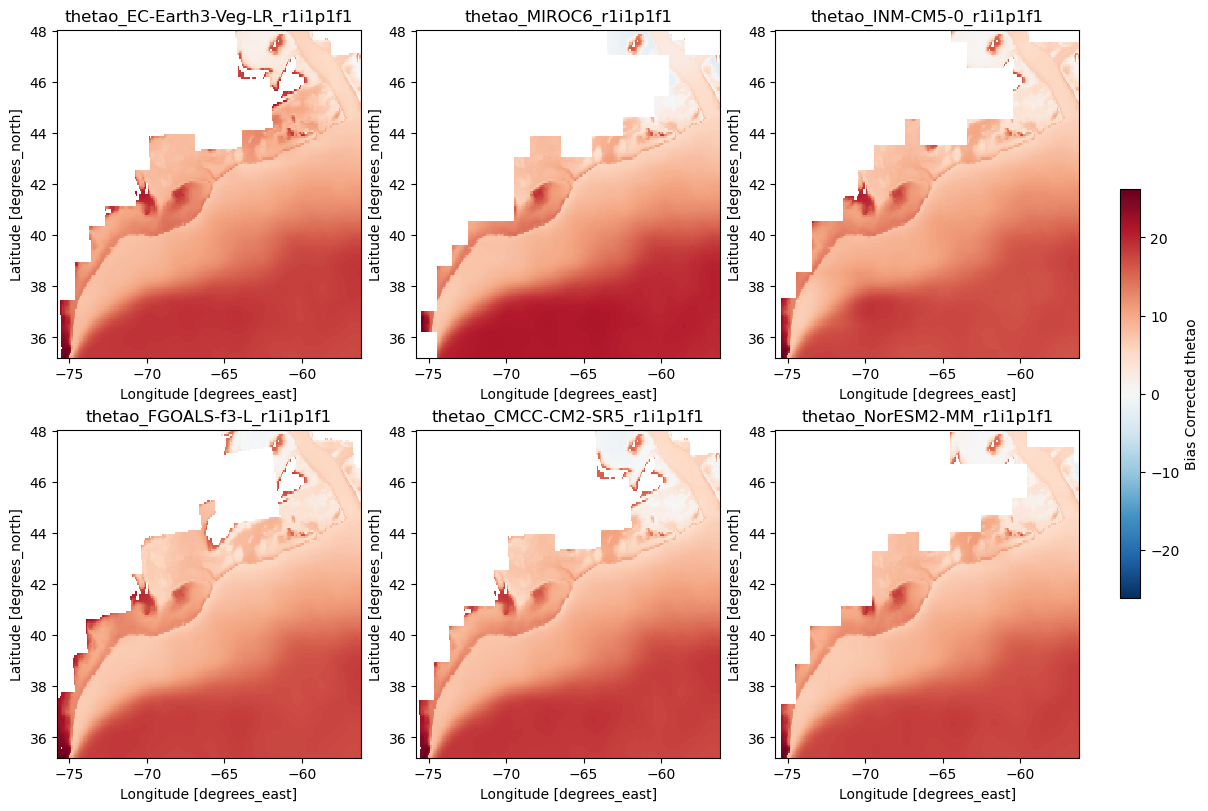

In [23]:
# Select datasets to plot
keys_to_plot = list(islice(corrected_ds.keys(), 6))
datasets_to_plot = [corrected_ds[key] for key in keys_to_plot]

# Create a 3x2 grid for plotting
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its corresponding subplot
for i, (data, ax) in enumerate(zip(datasets_to_plot, axes)):
    
    # Assuming time indexing, you might need to select a specific time index here:
    data = data.isel(time = 20)
    im = getattr(data, f"bias_corrected_{cmip_var}").plot(ax = ax, add_colorbar = False)
    ax.set_title(f"{keys_to_plot[i]}")  # Add title for clarity

# Add a single shared colorbar
cbar = fig.colorbar(im, ax = axes, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label(f"Bias Corrected {cmip_var}")

# Hide any unused axes if datasets < grid size
for ax in axes[len(datasets_to_plot):]:
    ax.axis("off")

# Show the plot
plt.show()

# Save Individual Model Corrections

To make any of the spaghetti plot figures we need to be able to trace projections back to individual models. For this we can save each bias-corrected dataset as its own file for later.

In [24]:
# Calendars again!
# Standardize all datasets in the dictionary
for key, ds in corrected_ds.items():

    # Extract the current calendar
    current_calendar = ds.time.values[0].calendar
    
    # If its not target, change it
    is_correct = current_calendar == TARGET_CALENDAR
    if is_correct:
        print(f"{key} matches the TARGET_CALENDAR: {TARGET_CALENDAR}")
    if is_correct == False:
        print(f"{key} does not match the TARGET_CALENDAR: {TARGET_CALENDAR}")

thetao_EC-Earth3-Veg-LR_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_MIROC6_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_INM-CM5-0_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_FGOALS-f3-L_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_CMCC-CM2-SR5_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_NorESM2-MM_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_IPSL-CM6A-LR_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_NorESM2-LM_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_FGOALS-g3_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_CESM2-WACCM_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_NESM3_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_EC-Earth3-Veg_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_EC-Earth3_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_INM-CM4-8_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_CIESM_r1i1p1f1 matches the TARGET_CALENDAR: noleap
thetao_CNRM-ESM2-1_r4i1p1f2 matches the TARGET_CALENDAR: n

## Standardize Calendar/Dates and Save

In [26]:
def standardize_to_mid_month(time_values, target_calendar):
    """Convert time array to a target calendar with a standardized day (15th)."""
    standardized_dates = []
    
    for t in time_values:
        if isinstance(t, cftime.datetime):  # If cftime-based
            standardized_dates.append(cftime.datetime(t.year, t.month, 15, calendar = target_calendar))
        
        elif isinstance(t, np.datetime64):  # If numpy.datetime64
            # Convert to a standard cftime object
            t = t.astype('datetime64[M]').astype(str)  # Extract year and month
            year, month = map(int, t.split("-"))
            standardized_dates.append(cftime.datetime(year, month, 15, calendar = target_calendar))
        else:
            raise ValueError(f"Unsupported time type: {type(t)}")

    return standardized_dates

In [27]:
# Change them to be consistent
standardized_dates = {}
for key, ds in corrected_ds.items():

    # Standardize the calendar type and day in month
    time_values = ds.time.values
    current_calendar = time_values[0].calendar
    #print(f"{key} is originally {current_calendar}")
    
    # Standardize dates to the 15th and convert to the "noleap" calendar
    new_time = standardize_to_mid_month(time_values, target_calendar = TARGET_CALENDAR)

    # Assign the standardized time back to the dataset
    ds = ds.assign_coords(time=new_time)
    standardized_dates[key] = ds

    # Make the path out
    save_path = f'{ExperimentPath}GLORYS_Bias_Corrected/IndividualModels/{var_choice}/{key}.nc'

    # Save it
    print(f"Saving Bias Corrections: {save_path}")
    ds.to_netcdf(save_path)


Saving Bias Corrections: /Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/SSP5_85/GLORYS_Bias_Corrected/IndividualModels/bot_temp/thetao_EC-Earth3-Veg-LR_r1i1p1f1.nc
Saving Bias Corrections: /Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/SSP5_85/GLORYS_Bias_Corrected/IndividualModels/bot_temp/thetao_MIROC6_r1i1p1f1.nc
Saving Bias Corrections: /Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/SSP5_85/GLORYS_Bias_Corrected/IndividualModels/bot_temp/thetao_INM-CM5-0_r1i1p1f1.nc
Saving Bias Corrections: /Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/SSP5_85/GLORYS_Bias_Corrected/IndividualModels/bot_temp/thetao_FGOALS-f3-L_r1i1p1f1.nc
Saving Bias Corrections: /Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/SSP5_85/GLORYS_Bias_Corrected/IndividualModels/bot_temp/thetao_CMCC-CM2-SR5_r1i1p1f1.nc
Saving Bias Corrections: /Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/SSP5_85/GLORYS_Bias_

---

I'm having issues with the percentiles for the collection. I was able to do this in R pretty easily, so for now I may hop over.

# Extract 5th, 50th, & 95th Percentile

Percentiles from the ensemble are what we will use for projections and for projection uncertainty. This next step will combine them and pull the 5th/50th/95th percentile from the collection.

In [32]:
# # Check calendars are the same: good
# for key, ds in standardized_dates.items():
#     time_type = type(ds['time'].values[0])
#     calendar = getattr(ds['time'].values[0], 'calendar', 'None')
#     print(f"{key}: {time_type}, Calendar: {calendar}")

# Extract a reference time coordinate (e.g., from the first dataset)
ref_time = standardized_dates[next(iter(standardized_dates))]['time']

# Reindex all datasets to align with the reference time
aligned_datasets = {
    key: ds.interp(time = ref_time, method='nearest') for key, ds in standardized_dates.items()
}

# # Concatenate datasets along the 'source' dimension
# ensemble_data = xr.concat(
#     [ds[f"bias_corrected_{cmip_var}"] for ds in aligned_datasets.values()],
#     dim = 'source')
# ensemble_data = ensemble_data.assign_coords(time=ref_time)
# ensemble_data

def assign_year_month(ds):
    """Add a year-month coordinate for grouping."""
    #cyear_month = pd.to_datetime(ds['time'].values).to_period('M').to_timestamp()
    year_month = [cftime.datetime(t.year, t.month, 15, calendar=t.calendar) for t in ds['time'].values]
    return ds.assign_coords(year_month=("time", year_month))

def compute_year_month_quantiles(datasets, variable, quantiles):
    """Compute quantiles by year-month across multiple datasets."""
    # Standardize to year-month and stack along a new dimension
    datasets_with_ym = [assign_year_month(ds) for ds in datasets]
    
    # Combine datasets along a new 'source' dimension
    combined = xr.concat(datasets_with_ym, dim='source')
    combined = combined.chunk({'source': -1})  # Combine all chunks along 'source'
    
    # Group by year-month and compute quantiles
    return combined[variable].groupby("year_month").quantile(quantiles, dim="source")

# Define quantiles
quantiles = [0.05, 0.5, 0.95]  

# Run it
result = compute_year_month_quantiles(aligned_datasets, f"bias_corrected_{cmip_var}", quantiles)
result

TypeError: string indices must be integers

In [66]:
# # Calculate statistics across 'source' dimension for each timestep and location
# ensemble_median = ensemble_data.median(dim = 'source')
# ensemble_p5     = ensemble_data.quantile(0.05, dim = 'source')
# ensemble_p95    = ensemble_data.quantile(0.95, dim = 'source')

# # Combine results into a new dataset for convenience
# ensemble_result = xr.Dataset({
#     'median_sst': median_sst,
#     'p5_sst': p5_sst,
#     'p95_sst': p95_sst
# })
# ensemble_result

ValueError: dimension source on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single array chunk along this dimension, i.e., ``.chunk(dict(source=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

---
# Everything below is sandboxing stuff

In [23]:

# # This is an attempt to strip out the important information and throw it into a new array using its lat/lon coords:

# # Can we flatten/reconstruct the arrays for a single variable from here?
# def simplify_grid(xr_ds, time_var = "time", var = "thetao"):

#     # Convert to nominal x, y indexing
#     # Only perform if its an irregular grid situation
#     is_irregular = xr_ds["lon"].ndim == 2
#     if(is_irregular):
#         xr_ds = replace_x_y_nominal_lat_lon(xr_ds)

#     # Take the data values out as an array
#     data = xr_ds[var].values 
    
#     # Pull the coordinates
#     time      = xr_ds.coords[time_var]
#     longitude = xr_ds.coords['x'] - 360 # because we know glorys is -180 to 180
#     latitude  = xr_ds.coords['y']

#     # Building an xr.array
#     xr_manual = xr.DataArray(data, coords = [time, latitude, longitude]).rename({"x": "longitude", "y" : "latitude"})
#     return xr_manual

# ------------------


# # The following chunk is just for identifying the irregular grids
# # Multi-Index checking

# # If multi-index, replace x,y nominal
# # Check if its a multiIndex / irregular grid situation
# for id, dataset in concatenated_datasets.items():
#     print(f"Checking: {id}")
#     is_irregular = dataset["lon"].ndim == 2
#     print(is_irregular)

# # # This one was True above - works
# # replace_x_y_nominal_lat_lon(concatenated_datasets["tos_EC-Earth3-Veg-LR_r1i1p1f1"])

# # # This one was false above - fails
# # replace_x_y_nominal_lat_lon(concatenated_datasets["tos_MRI-ESM2-0_r1i1p1f1"])



#--------------------

# # The following code is for interpolating using xarray, does not work for all

# # Process all matched files
# interp_datasets = {}
# for key, concat_ds in concatenated_datasets.items():
    
#     # # Convert to nominal x, y indexing
#     # concat_ds = replace_x_y_nominal_lat_lon(concat_ds)
#     simple_ds = simplify_grid(concat_ds, var = cmip_var)

#     # Interpolate
#     interp_datasets[key] = simple_ds.interp(
#         latitude = glorys_clim.latitude,   # Match latitude
#         longitude = glorys_clim.longitude  # Match longitude
#     )
